# Module work № 1

In this work the task about prediction of Air quality index (AQI) based on features about concentrations of different chemical components is given. The dataset `station_day.csv` was retrieved from the Kaggle [repository](https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india?select=station_hour.csv) of data about air quality in Indian cities.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split

In [2]:
%pylab inline 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [41]:
air_quality = pd.read_csv('station_day.csv')
air_quality.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


There are 14 features in the dataset:
- **StationId** - id of the station
- **Date** - date of the observation

Next features show concentrations of different chemicals in µg/m<sup>3</sup>:
- **PM2.5** - solid particles with size 2.5 micrometer
- **PM10** - solid particles with size 10 micrometer
- **NO** - nitric oxide
- **NO2** - nitric dioxide
- **NOx** - other nitric oxide
- **NH3** - ammonia
- **CO** - carbon oxide
- **SO2** - sulfur dioxide
- **O3** - ozone
- **Benzene**
- **Toluene**
- **Xylene**

The last two features show AQI index:
- **AQI** - air quality index value in numbers
- **AQI_Bucket** - air quality index class

In [42]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB


For 108035 observations there are only 87025 values of the AQI index, it means that there are missed values in AQI feature, and they should be removed:

In [43]:
air_quality.dropna(subset='AQI', inplace=True)

For the purpose of the work, StationId, Date and AQI_Bucket columns were deleted since they can't be used in the classical regression model:

In [44]:
air_quality.drop(['StationId', 'Date', 'AQI_Bucket'], axis=1, inplace=True)

In [45]:
air_quality.rename({'PM2.5': 'PM2_5'}, axis=1, inplace=True)

In [46]:
air_quality.head()

,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
1,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0
2,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0
3,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0
4,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0
5,72.47,114.84,5.23,23.20,16.59,12.25,0.16,10.55,109.74,0.21,4.71,0.08,173.0


Now the dataset is ready for data analysis

In [47]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87025 entries, 1 to 108034
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM2_5    83537 non-null  float64
 1   PM10     63064 non-null  float64
 2   NO       84796 non-null  float64
 3   NO2      85459 non-null  float64
 4   NOx      82470 non-null  float64
 5   NH3      57193 non-null  float64
 6   CO       84129 non-null  float64
 7   SO2      77492 non-null  float64
 8   O3       77427 non-null  float64
 9   Benzene  67238 non-null  float64
 10  Toluene  60701 non-null  float64
 11  Xylene   19441 non-null  float64
 12  AQI      87025 non-null  float64
dtypes: float64(13)
memory usage: 9.3 MB


There are 87025 observations remained in the dataset, but still there are missed values in all columns except the target feature. In order to fill empty values, mean value of each column was used:

In [48]:
for col in air_quality.columns:
    air_quality[col].fillna(air_quality[col].mean(), inplace=True)

In [49]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87025 entries, 1 to 108034
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM2_5    87025 non-null  float64
 1   PM10     87025 non-null  float64
 2   NO       87025 non-null  float64
 3   NO2      87025 non-null  float64
 4   NOx      87025 non-null  float64
 5   NH3      87025 non-null  float64
 6   CO       87025 non-null  float64
 7   SO2      87025 non-null  float64
 8   O3       87025 non-null  float64
 9   Benzene  87025 non-null  float64
 10  Toluene  87025 non-null  float64
 11  Xylene   87025 non-null  float64
 12  AQI      87025 non-null  float64
dtypes: float64(13)
memory usage: 9.3 MB


### Exploratory data analysis

Let's begin with descriptive statistics:

In [50]:
desc_stat = air_quality.describe().applymap("{0:.2f}".format)
desc_stat

,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,87025.00,87025.00,87025.00,87025.00,87025.00,87025.00,87025.00,87025.00,87025.00,87025.00,87025.00,87025.00,87025.00
mean,80.39,158.56,23.24,35.12,43.25,28.65,1.62,12.21,38.32,3.57,16.56,2.77,179.75
std,74.42,105.21,34.22,28.76,44.19,19.47,4.18,11.76,37.33,10.11,25.33,3.26,131.32
min,0.04,0.03,0.02,0.01,0.00,0.01,0.00,0.01,0.01,0.00,0.00,0.00,8.00
25%,32.96,89.37,4.92,15.39,16.16,18.00,0.61,5.53,20.42,0.48,2.30,2.77,86.00
50%,58.53,158.56,10.62,27.79,30.04,28.65,0.98,10.19,34.22,2.53,16.19,2.77,132.00
75%,97.33,167.02,24.18,46.29,50.47,29.74,1.56,13.96,44.66,3.57,16.56,2.77,254.00
max,1000.00,976.77,437.85,448.05,434.90,365.68,175.81,186.08,963.00,455.03,454.85,170.37,2049.00


There may be extreme outliers in the dataset, according to descriptive statistics, since max values of the majority of features are extremely high

Text(0.5, 1.0, 'AQI distribution')

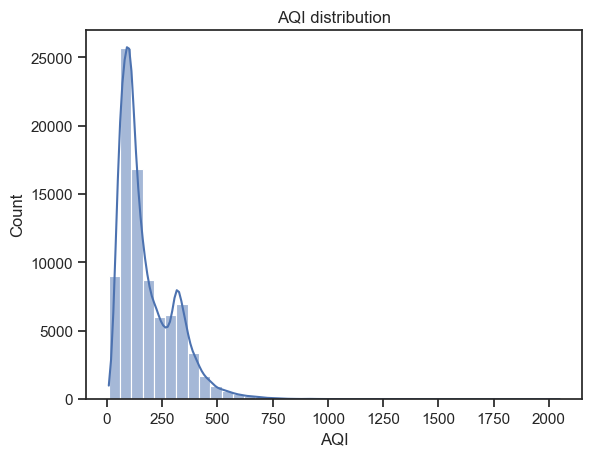

In [51]:
sns.set_theme(style='ticks')
sns.histplot(data=air_quality.AQI, bins=40, kde=True)
plt.title("AQI distribution")

The distribution of the target value is not normal, with the majority of objects in the least values of the index and with the minority of objects in the biggest values of the index

Let's find outliers of the dataset using boxplots:

Text(0.5, 0.98, 'Outliers of feautres')

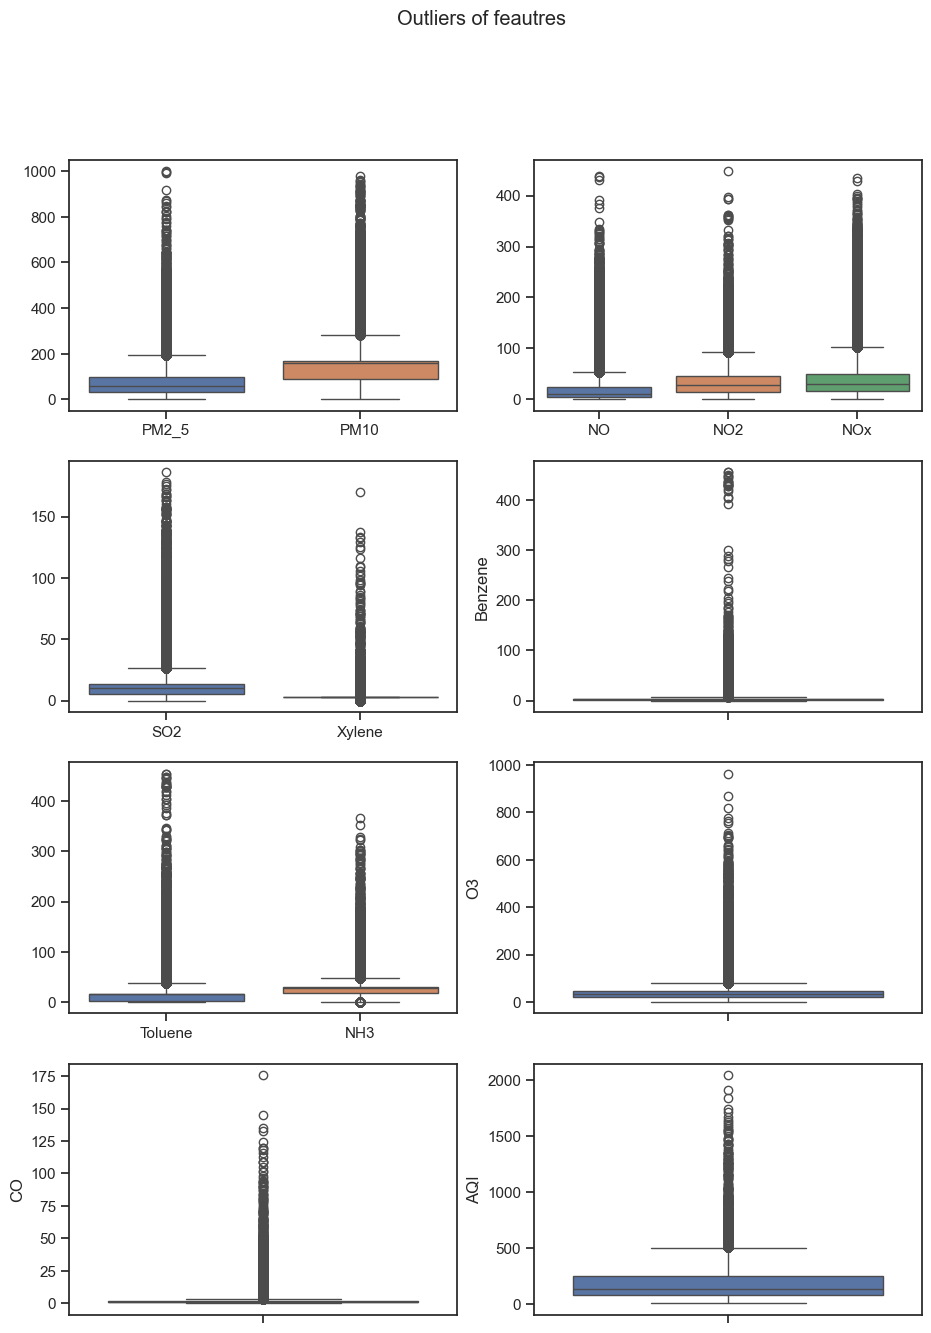

In [52]:
sns.set_theme(style='ticks')
fig, axes = plt.subplots(4, 2, figsize = (11, 15))
sns.boxplot(data = air_quality[['PM2_5', 'PM10']], ax=axes[0, 0])
sns.boxplot(data = air_quality[['NO', 'NO2', 'NOx']], ax=axes[0, 1])
sns.boxplot(data = air_quality[['SO2', 'Xylene']], ax=axes[1, 0])
sns.boxplot(data = air_quality['Benzene'], ax=axes[1, 1])
sns.boxplot(data = air_quality['O3'], ax=axes[2, 1])
sns.boxplot(data = air_quality[['Toluene', 'NH3']], ax=axes[2, 0])
sns.boxplot(data = air_quality['CO'], ax=axes[3, 0])
sns.boxplot(data = air_quality['AQI'], ax=axes[3, 1])

plt.suptitle('Outliers of feautres')

Since Xylene feature had a lot of outliers and practically the majority of values of the column was replaced by mean value, it is better to delete this feature:

In [53]:
del air_quality['Xylene']

How many outliers in each column:

In [54]:
for feature in list(air_quality.columns):
    iqr = air_quality[feature].quantile(q=0.75) - air_quality[feature].quantile(q=0.25)
    quantile_1 = air_quality[feature].quantile(q=0.25)
    quantile_3 = air_quality[feature].quantile(q=0.75)
    outliers = air_quality[(air_quality[feature] < (quantile_1-1.5*iqr)) | (air_quality[feature] > (quantile_3+1.5*iqr))]
    print(feature + ": " + str(outliers.shape[0]))

PM2_5: 6849
PM10: 9044
NO: 9844
NO2: 3697
NOx: 7608
NH3: 8871
CO: 5081
SO2: 6118
O3: 3891
Benzene: 6372
Toluene: 7404
AQI: 1795


Let's delete all of them:

In [55]:
for col in air_quality.columns:
    iqr = air_quality[col].quantile(q=0.75) - air_quality[col].quantile(q=0.25)
    quantile_1 = air_quality[col].quantile(q=0.25)
    quantile_3 = air_quality[col].quantile(q=0.75)
    air_quality = air_quality[(air_quality[col] >= (quantile_1-1.5*iqr)) & (air_quality[col] <= (quantile_3+1.5*iqr))]
    air_quality.shape

In [56]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45742 entries, 15 to 108034
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM2_5    45742 non-null  float64
 1   PM10     45742 non-null  float64
 2   NO       45742 non-null  float64
 3   NO2      45742 non-null  float64
 4   NOx      45742 non-null  float64
 5   NH3      45742 non-null  float64
 6   CO       45742 non-null  float64
 7   SO2      45742 non-null  float64
 8   O3       45742 non-null  float64
 9   Benzene  45742 non-null  float64
 10  Toluene  45742 non-null  float64
 11  AQI      45742 non-null  float64
dtypes: float64(12)
memory usage: 4.5 MB


Now dataset has 45742 columns

There are several ways to deal with multicollinearity, including building a correlation matrix and searching for variables that are highly correlated with each other

In [57]:
air_quality.corr()

,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
PM2_5,1.000000,0.502749,0.195371,0.331374,0.286336,0.281378,0.232241,0.132341,0.223824,0.228027,0.134941,0.715933
PM10,0.502749,1.000000,0.123988,0.258020,0.209973,0.430549,0.310159,0.086399,0.149762,0.081689,-0.060715,0.576554
NO,0.195371,0.123988,1.000000,0.367755,0.664142,0.084532,0.189832,0.157368,-0.097403,0.117836,0.173418,0.220425
NO2,0.331374,0.258020,0.367755,1.000000,0.649555,0.181400,0.194374,0.120734,0.167648,0.157406,0.133157,0.347645
NOx,0.286336,0.209973,0.664142,0.649555,1.000000,0.157475,0.224427,0.131795,0.029914,0.181504,0.168553,0.284183
NH3,0.281378,0.430549,0.084532,0.181400,0.157475,1.000000,0.251566,0.116039,0.075746,0.020736,0.005179,0.253945
CO,0.232241,0.310159,0.189832,0.194374,0.224427,0.251566,1.000000,0.069642,0.069042,0.106838,0.082846,0.283937
SO2,0.132341,0.086399,0.157368,0.120734,0.131795,0.116039,0.069642,1.000000,0.112194,0.036019,0.157521,0.247789
O3,0.223824,0.149762,-0.097403,0.167648,0.029914,0.075746,0.069042,0.112194,1.000000,0.088657,0.041617,0.278579
Benzene,0.228027,0.081689,0.117836,0.157406,0.181504,0.020736,0.106838,0.036019,0.088657,1.000000,0.519339,0.121447


Text(0.5, 1.0, 'Linear correlation matrix')

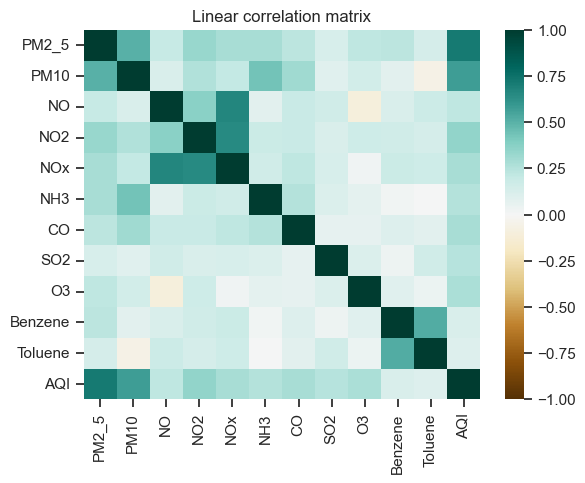

In [59]:
sns.heatmap(data=air_quality.corr(), vmin=-1, vmax=1, cmap='BrBG')
plt.title("Linear correlation matrix")

The majority of features doesn't correlate with AQI column strongly, except PM2_5 column

In [22]:
import pingouin as pg

In [23]:
air_quality.pcorr()

,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
PM2_5,1.000000,0.103658,-0.003645,0.041578,0.039496,0.103890,-0.026859,-0.075460,0.028582,0.161370,0.006851,0.564564
PM10,0.103658,1.000000,-0.027659,0.025626,0.013168,0.321599,0.131887,-0.058726,-0.026671,0.080335,-0.179485,0.345639
NO,-0.003645,-0.027659,1.000000,-0.100176,0.578772,-0.030350,0.059347,0.083760,-0.166456,-0.033886,0.075648,0.072886
NO2,0.041578,0.025626,-0.100176,1.000000,0.545290,0.035664,0.004332,0.000385,0.118985,0.008787,0.018624,0.083233
NOx,0.039496,0.013168,0.578772,0.545290,1.000000,0.027451,0.049472,-0.003607,-0.012674,0.063223,-0.003575,-0.028067
NH3,0.103890,0.321599,-0.030350,0.035664,0.027451,1.000000,0.132743,0.088397,-0.000102,-0.063048,0.027744,-0.095144
CO,-0.026859,0.131887,0.059347,0.004332,0.049472,0.132743,1.000000,-0.020360,0.006033,0.035101,0.034999,0.089727
SO2,-0.075460,-0.058726,0.083760,0.000385,-0.003607,0.088397,-0.020360,1.000000,0.067517,-0.057480,0.131097,0.194869
O3,0.028582,-0.026671,-0.166456,0.118985,-0.012674,-0.000102,0.006033,0.067517,1.000000,0.054848,-0.012835,0.161057
Benzene,0.161370,0.080335,-0.033886,0.008787,0.063223,-0.063048,0.035101,-0.057480,0.054848,1.000000,0.505306,-0.105210


Text(0.5, 1.0, 'Partial correlation matrix')

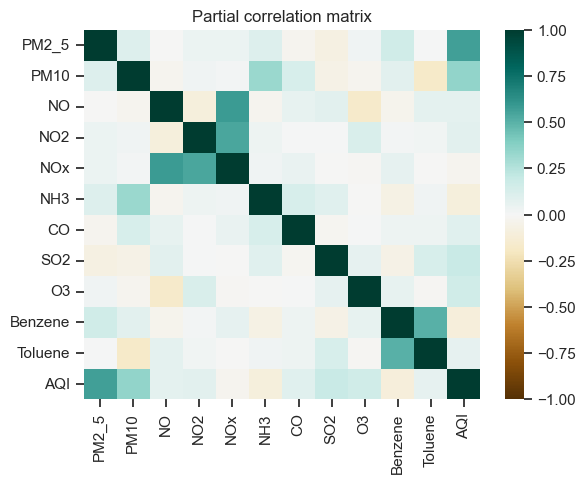

In [60]:
sns.heatmap(data=air_quality.pcorr(), vmin=-1, vmax=1, cmap='BrBG')
plt.title("Partial correlation matrix")

The next method is to calculate the variance inflation factor (VIF) for independent variables. Let's calculate VIF:

In [61]:
X = air_quality.drop('AQI', axis=1)
vif=pd.DataFrame()
vif['feature']=X.columns
vif['VIF']=[variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif

,feature,VIF
0,PM2_5,6.290917
1,PM10,8.577893
2,NO,4.354405
3,NO2,6.786562
4,NOx,9.669607
5,NH3,6.401765
6,CO,4.901969
7,SO2,3.925879
8,O3,4.676858
9,Benzene,3.171945


All VIF coefficients are less than 10, so we can use all features for regression analysis

## Regression analysis

Classical regression model:

In [62]:
m1=smf.ols('AQI~ PM2_5+PM10+NO+NO2+NOx+NH3+CO+SO2+O3+Benzene+Toluene', 
          data=air_quality)
fitted=m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     6916.
Date:                Mon, 25 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:06:03   Log-Likelihood:            -2.1899e+05
No. Observations:               45742   AIC:                         4.380e+05
Df Residuals:                   45730   BIC:                         4.381e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7401      0.506     11.340      0.0

As regression model summary shows, both R-squared are quite small, and it shows underfitting of the model. Yet, all coefficients of the model are good since their confidence interval don't intersect zero and all model is significant according to p-value of F-statistic. There are three negative coefficients, others are positive.

### Heteroskedasticity

Heteroskedasticity test is needed to find the relation between value of the predicted value and errors of the model. Scatterplots may be one of the ways to find heteroskedasticity:

In [63]:
intercept,beta_PM2_5,beta_PM10,beta_NO,beta_NO2,beta_NOx,beta_NH3,beta_CO,beta_SO2,beta_O3,beta_Benzene,beta_Toluene = fitted.params

In [64]:
AQI_pred = intercept + beta_PM2_5 * air_quality['PM2_5'] + beta_PM10 * air_quality['PM10'] + beta_NO * air_quality['NO'] + \
            beta_NO2 * air_quality['NO2'] + beta_NOx * air_quality['NOx'] + beta_NH3 * air_quality['NH3'] + \
            beta_CO * air_quality['CO'] + beta_SO2 * air_quality['SO2'] + beta_O3 * air_quality['O3'] + \
            beta_Benzene * air_quality['Benzene'] + beta_Toluene * air_quality['Toluene'] 

In [65]:
res = air_quality['AQI'] - AQI_pred
res

15        30.031491
16         9.251783
17         3.494568
18        23.605186
19        23.502577
            ...    
108029     3.108696
108030     9.913992
108031    19.957932
108033     9.415980
108034    26.367790
Length: 45742, dtype: float64

In [66]:
import random

Text(0.5, 0.98, 'Heteroskedasticity on graphs')

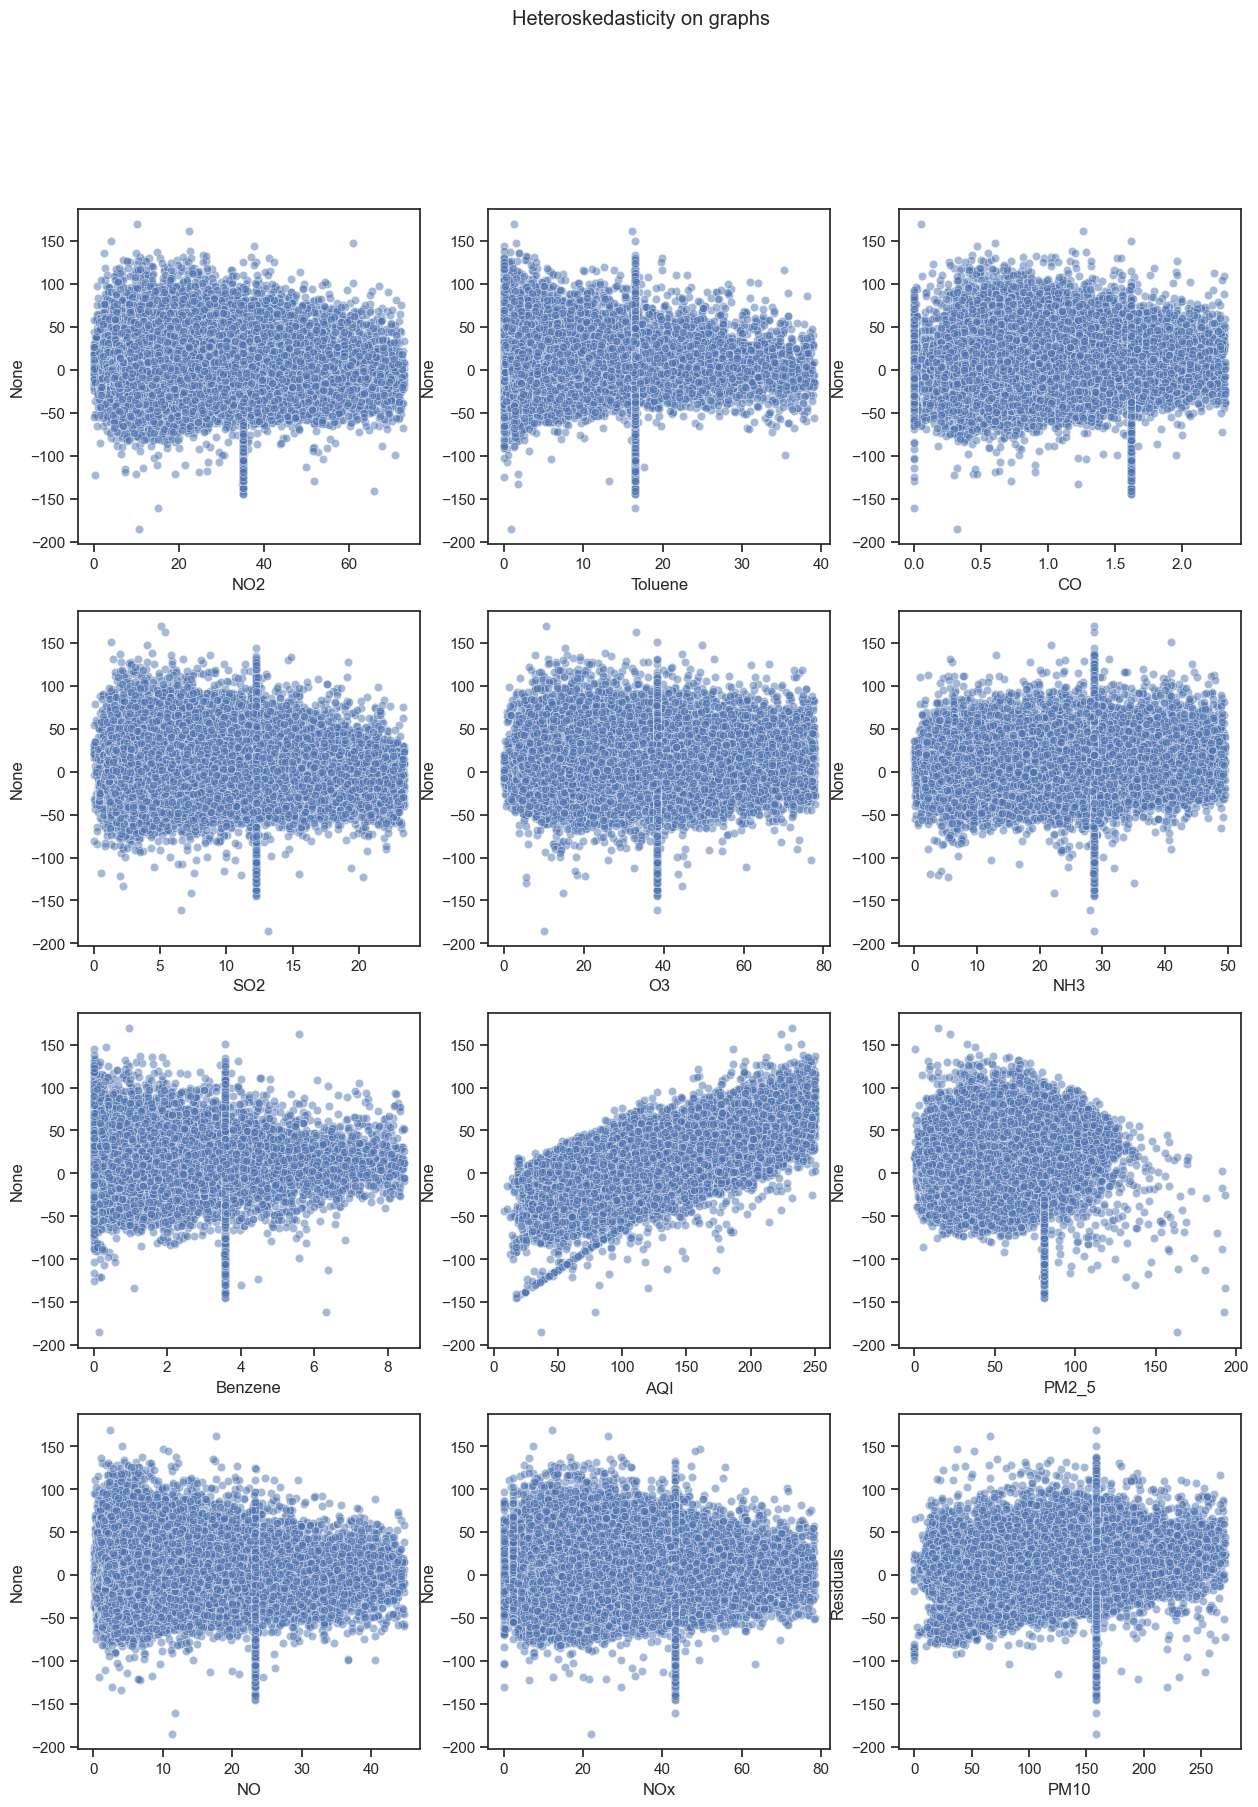

In [67]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,20))

col_list = list(air_quality.columns)
for row in range(0,4):
    for col in range(0,3):
        selected_col = random.choice(col_list)
        sns.scatterplot(x=air_quality[selected_col], y=res, alpha=0.5, ax=axes[row, col])
        col_list.remove(selected_col)
        plt.xlabel(selected_col)
        plt.ylabel('Residuals')
        
plt.suptitle('Heteroskedasticity on graphs')

As it is seen on the graphs, there may be heteroskedasticity. Let's check it on the statistical tests:

In [68]:
bp_test = het_breuschpagan(res, fitted.model.exog)

labels = ['het_breuschpagan test statistic', 'p-value', 'F-statistic', 'F-test p-value']

for name, value in zip(labels, bp_test):
    print(f"{name}: {round(value, 2)}")

het_breuschpagan test statistic: 4024.24
p-value: 0.0
F-statistic: 401.03
F-test p-value: 0.0


In [69]:
het_white_test = het_white(res, fitted.model.exog)

labels = ['het_white test statistic', 'p-value', 'F-statistic', 'F-test p-value']

for name, value in zip(labels, het_white_test):
    print(f"{name}: {round(value, 2)}")

het_white test statistic: 6895.33
p-value: 0.0
F-statistic: 105.27
F-test p-value: 0.0


As these tests show, there is a heteroskedasticity in the dataset

Let's apply robust standard errors for regression model:

In [70]:
m_hc1 = smf.ols('AQI~ PM2_5+PM10+NO+NO2+NOx+NH3+CO+SO2+O3+Benzene+Toluene',
                data=air_quality)
fitted_hc1 = m_hc1.fit(cov_type='HC1')
print(fitted_hc1.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     6616.
Date:                Mon, 25 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:06:22   Log-Likelihood:            -2.1899e+05
No. Observations:               45742   AIC:                         4.380e+05
Df Residuals:                   45730   BIC:                         4.381e+05
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7401      0.438     13.119      0.0

### Error analysis of model with robust errors

In [71]:
intercept,beta_PM2_5,beta_PM10,beta_NO,beta_NO2,beta_NOx,beta_NH3,beta_CO,beta_SO2,beta_O3,beta_Benzene,beta_Toluene = fitted_hc1.params

In [36]:
AQI_pred = intercept + beta_PM2_5 * air_quality['PM2_5'] + beta_PM10 * air_quality['PM10'] + beta_NO * air_quality['NO'] + \
            beta_NO2 * air_quality['NO2'] + beta_NOx * air_quality['NOx'] + beta_NH3 * air_quality['NH3'] + \
            beta_CO * air_quality['CO'] + beta_SO2 * air_quality['SO2'] + beta_O3 * air_quality['O3'] + \
            beta_Benzene * air_quality['Benzene'] + beta_Toluene * air_quality['Toluene'] 

Text(0, 0.5, 'Count')

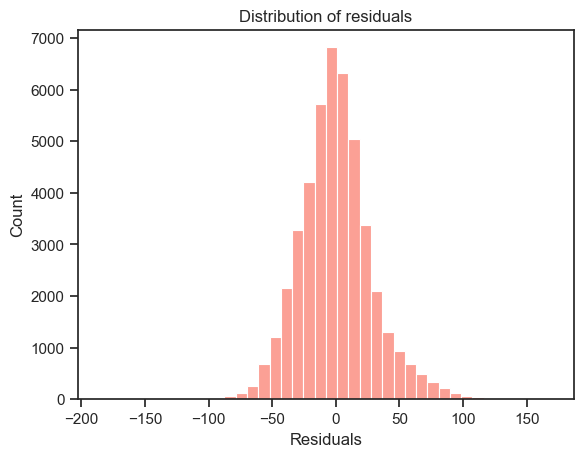

In [72]:
sns.histplot(fitted_hc1.resid, kde=False, bins=40, color='salmon')
plt.title("Distribution of residuals")
plt.xlabel("Residuals")
plt.ylabel("Count")

The distribution of errors is normal, with the mean value equal to zero

Text(0.5, 1.0, 'True values vs Predicted values AQI')

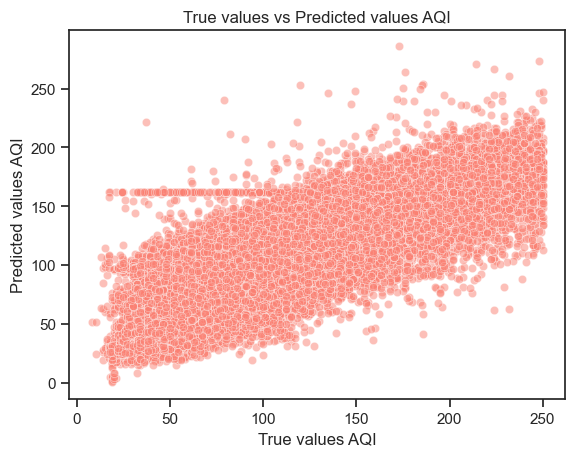

In [73]:
sns.scatterplot(x=air_quality['AQI'], y=fitted_hc1.fittedvalues, color='salmon', alpha=0.5)
plt.xlabel('True values AQI')
plt.ylabel('Predicted values AQI')
plt.title("True values vs Predicted values AQI")

Text(0.5, 1.0, 'Predicted values vs Error')

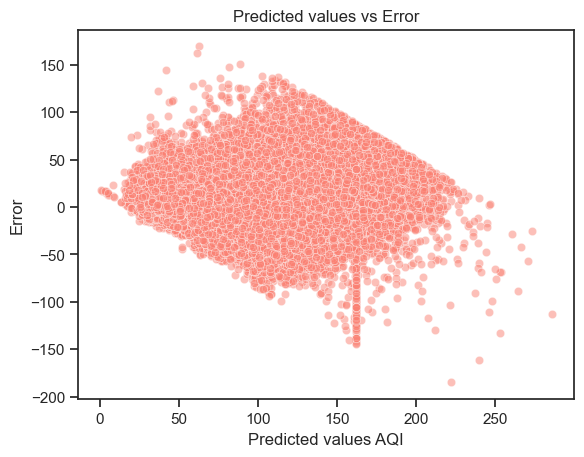

In [74]:
sns.scatterplot(x=fitted_hc1.fittedvalues, y=fitted_hc1.resid, color='salmon', alpha=0.5)
plt.xlabel('Predicted values AQI')
plt.ylabel('Error')
plt.title("Predicted values vs Error")

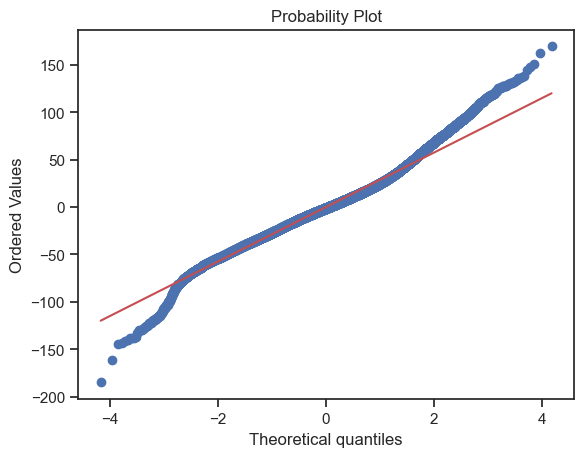

In [75]:
sc.stats.probplot(fitted.resid, dist='norm', plot=pylab)
plt.show()

## Model regularization

In order to compare importance of each coefficient of regression model, dataset should be normalized:

In [76]:
scaler = MinMaxScaler()
scaler.fit(air_quality)
air_quality_std=scaler.transform(air_quality)

air_quality_norm = pd.DataFrame(air_quality_std)
air_quality_norm.columns=air_quality.columns

In [77]:
X = air_quality_norm.drop('AQI', axis=1)
y = air_quality_norm['AQI']

Let's build model without regularization:

In [78]:
model=LinearRegression()
model.fit(X, y)

coef_importance = pd.DataFrame(model.coef_, index = X.columns, columns = ["weight"])
coef_importance.loc['Intercept'] = model.intercept_

coef_importance

,weight
PM2_5,0.775181
PM10,0.289031
NO,0.063385
NO2,0.068349
NOx,-0.028196
NH3,-0.060926
CO,0.059015
SO2,0.118434
O3,0.097421
Benzene,-0.075373


There are some features with coefficients close to zero, may be regularization will select most important coefficients

### Ridge regularization:

At first, let's choose the best alpha value for ridge regularization:

In [79]:
reg_ridge=RidgeCV(alphas=[0.01, 0.1, 0.5, 1]).fit(X,y)
print(reg_ridge.alpha_)

0.1


Now we can build model with regularization:

In [80]:
ridge_coef_importance = pd.DataFrame(reg_ridge.coef_, index = X.columns, columns = ["ridge_weight"])
ridge_coef_importance.loc['Intercept'] = reg_ridge.intercept_

ridge_coef_importance

,ridge_weight
PM2_5,0.775048
PM10,0.289044
NO,0.063381
NO2,0.068354
NOx,-0.028179
NH3,-0.060909
CO,0.059017
SO2,0.118433
O3,0.097429
Benzene,-0.075353


Values of coefficients became slightly smaller than values of coefficients in the previous model

In [81]:
reg_ridge.score(X,y)

0.6245513539224765

R-squared doesn't changed significantly

### Lasso regulariation

In [82]:
reg_lasso=LassoCV(cv=5, random_state=8).fit(X,y)

In [83]:
lasso_coef_importance = pd.DataFrame(reg_lasso.coef_, index = X.columns, columns = ["lasso_weight"])
lasso_coef_importance.loc['Intercept'] = reg_lasso.intercept_

lasso_coef_importance

,lasso_weight
PM2_5,0.773971
PM10,0.288396
NO,0.061616
NO2,0.066932
NOx,-0.025284
NH3,-0.059870
CO,0.058490
SO2,0.118198
O3,0.097090
Benzene,-0.074096


In [84]:
reg_lasso.score(X,y)

0.6245443050684631

The situation with lasso regularization is analogical with the previous model. It means that regularization is useless for our model since it is underfitted.

### Polynomial features

Polynomial features may be a solution to increase R-squared and make model better:

In [85]:
polynom=PolynomialFeatures(degree=2, interaction_only=True)
X_poly_i=polynom.fit_transform(X)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_i, y, random_state=0)

In [87]:
lr = LinearRegression().fit(X_train, y_train)
result = lr.predict(X_test)
print("Train: ", lr.score(X_train, y_train).round(2))
print("Test: ", lr.score(X_test, y_test).round(2))

Train:  0.7
Test:  0.69


Text(0.5, 1.0, 'True values vs Predicted values AQI')

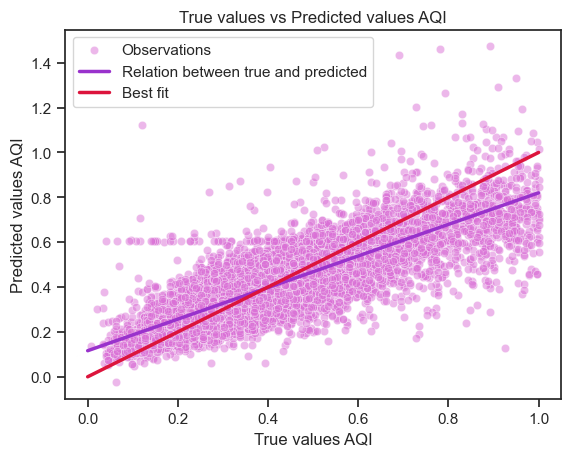

In [89]:
sns.scatterplot(x=y_test, y=result, color='orchid', alpha=0.5)
b, a = np.polyfit(y_test, result, deg=1)
seq = np.linspace(0,1)
line1 = plt.plot(seq, a + b * seq, color="darkorchid", lw=2.5)
line2 = sns.lineplot(x=[0,1], y=[0,1], color='crimson', lw=2.5)
plt.xlabel('True values AQI')
plt.ylabel('Predicted values AQI')
plt.legend(['Observations', 'Relation between true and predicted', 'Best fit'])
plt.title("True values vs Predicted values AQI")

As the graph shows, model tries to evaluate low values of the index higher, and evaluate high values of the index lower